In [1]:
#Installing the required libraries
! pip uninstall opencv-python -y
! pip uninstall opencv-contrib-python -y
! pip install opencv-python==3.4.11.45
! pip install opencv-contrib-python==3.4.11.45
! pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: opencv-python 3.4.11.45
Uninstalling opencv-python-3.4.11.45:
  Successfully uninstalled opencv-python-3.4.11.45
Found existing installation: opencv-contrib-python 3.4.11.45
Uninstalling opencv-contrib-python-3.4.11.45:
  Successfully uninstalled opencv-contrib-python-3.4.11.45
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached opencv_python-3.4.11.45-cp37-cp37m-manylinux2014_x86_64.whl (49.1 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached opencv_contrib_python-3.4.11.45-cp37-cp37m-manylinux2014_x86_64.whl (54.7 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time
import csv
import os
import pandas as pd
from numpy import genfromtxt
from google.colab.patches import cv2_imshow
from scipy import stats
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans,vq
from sklearn.svm import LinearSVC
from scipy.cluster.vq import vq
from texttable import Texttable
from sklearn.tree import DecisionTreeClassifier
import argparse
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import sklearn


### Data Extraction from zip file

In [3]:
!unzip /content/'CS67_Fall2022_ A1_Dataset.zip' -d /content/Dataset

Archive:  /content/CS67_Fall2022_ A1_Dataset.zip
replace /content/Dataset/00001/00025_00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/Dataset/00001/00025_00001.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Creating Train Test csv

In [4]:
label=0
#coverting .txt to .csv
#trainig data
for dir in os.listdir('/content/Dataset'): 
    label=int(dir)
    #reading train.txt file of every directory and writing path in train.csv
    file = open('/content/Dataset/'+str(dir)+'/train.txt', "r")  
    a=file.readlines()
    with open('train.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      for i in range(0,len(a)):
        writer.writerow(['/content/Dataset/'+str(dir)+'/'+str(a[i][:-1]), label])
    file.close()
    #test data
    file = open('/content/Dataset/'+str(dir)+'/test.txt', "r")
    a=file.readlines()
    #reading test.txt file of every directory and writing path in test.csv
    with open('test.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      for i in range(0,len(a)):
        writer.writerow(['/content/Dataset/'+str(dir)+'/'+str(a[i][:-1]), label])
    file.close()
    

### Reading train images and labels

In [76]:
training_images=[]
training_labels=[]
#Reading the train data csv files
read_training_img=pd.read_csv('train.csv', sep=',',header=None)
#Preprocessing
for i in range(0,len(read_training_img)):
  #reading training images 
  image=cv2.imread(read_training_img[0][i])
  #images to gray scale
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  #resizing images
  image=cv2.resize(image,(92,92))
  #Histogram equivalization for contrast enhancement
  image = cv2.equalizeHist(image)
  # Appending the images to training_images
  training_images.append(image)
  # appending the labels to the training_labels
  training_labels.append(read_training_img[1][i])
print(len(training_images))
  

800


### Reading test images and labels

In [77]:
testing_images=[]
testing_labels=[]
#Reading the test data csv files
read_test_img=pd.read_csv('test.csv', sep=',',header=None)
#Preprocessing
for i in range(0,len(read_test_img)):
  #reading test images 
  image=cv2.imread(read_test_img[0][i])
  #image to gray scale image
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  #resizing all images
  image=cv2.resize(image,(92,92))
  #histogram equilization
  image = cv2.equalizeHist(image)
  #appending preprocessed images to a test_images
  testing_images.append(image)
  #appending corresponding labels to test_labels
  testing_labels.append(read_test_img[1][i])
print(len(testing_images))

200


### Display Image and Labels

training label:  1
training image:


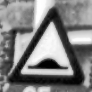

***************
training label:  2
training image:


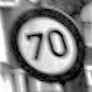

***************
training label:  3
training image:


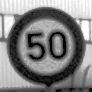

***************
training label:  4
training image:


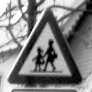

***************
training label:  5
training image:


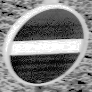

***************
training label:  6
training image:


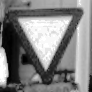

***************
training label:  7
training image:


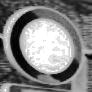

***************
training label:  8
training image:


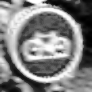

***************
training label:  9
training image:


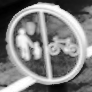

***************
training label:  10
training image:


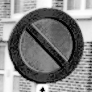

***************


In [78]:
ind=np.unique(training_labels,return_index=True)
for i in ind[1]:
  #displaying label of the image
  print("training label: ",training_labels[i])
  #displaying corresponding image
  print("training image:")
  cv2_imshow(training_images[i])
  print("***************")

### Two different Feature Extractors ORB and FAST+ BREIF were used along with SVM for classification. 
### FAST+BREIF and SVM combination was seen to have a higer accuracy.



# ORB + SVM

### Feature Extraction

In [79]:
descriptors=[]
keypoints=[]
training_dataset=[]
orb=cv2.ORB_create(nfeatures=200)
for i in range(0,len(training_images)):
  kp, descriptor = orb.detectAndCompute(training_images[i], None)

  if(len(kp)!=0):
      #appending the descriptors with non-Null values
      descriptors.append(descriptor)
      #appending the keypointss with non-Null values
      keypoints.append(kp)
      #appending the taining images with non-Null values
      training_dataset.append(read_training_img[1][i])   

### Stacking

In [80]:
#stacking the descriptors from training examples
ds=descriptors[0]
for descriptor in descriptors[1:]:
    ds=np.vstack((ds,descriptor))

### Keypoint Visualization

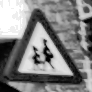

[<KeyPoint 0x7f85a6b80de0>, <KeyPoint 0x7f85a6c4f960>, <KeyPoint 0x7f85a6c4f4b0>, <KeyPoint 0x7f85a6c4f5a0>, <KeyPoint 0x7f85a6c4f540>, <KeyPoint 0x7f85a6c4f9f0>, <KeyPoint 0x7f85a6c4ff90>, <KeyPoint 0x7f85a6c4fa50>, <KeyPoint 0x7f85a6c4f7b0>, <KeyPoint 0x7f85a6c4fba0>, <KeyPoint 0x7f85a6c4f900>, <KeyPoint 0x7f85a6c4f030>, <KeyPoint 0x7f85a6c4f660>, <KeyPoint 0x7f85a6c4f2d0>, <KeyPoint 0x7f85a6c4fea0>, <KeyPoint 0x7f85a6c4f750>, <KeyPoint 0x7f85a6c4fa20>, <KeyPoint 0x7f85a6c4ff60>, <KeyPoint 0x7f85a6c4fae0>, <KeyPoint 0x7f85a6c4fd50>, <KeyPoint 0x7f85a6c4f690>, <KeyPoint 0x7f85a6c4f810>, <KeyPoint 0x7f85a6c4f990>, <KeyPoint 0x7f85a6c4f1e0>, <KeyPoint 0x7f85a6c4fb10>, <KeyPoint 0x7f85a6c4f270>, <KeyPoint 0x7f85a6c4f210>, <KeyPoint 0x7f85a6c4f2a0>, <KeyPoint 0x7f85a6c4f870>, <KeyPoint 0x7f85a6c4fd20>, <KeyPoint 0x7f85a6c4f840>, <KeyPoint 0x7f85a6c4f180>]


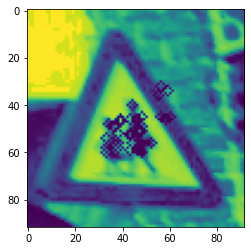

In [81]:
def show_keypoints(visual, keypoints, color = (0, 255, 255)):
  cv2_imshow(visual)
  for kp in keypoints:
    x, y = kp.pt
    plt.imshow(cv2.circle(visual, (int(x), int(y)), 2, color))

#displaying keypoints of a training example
show_keypoints(training_images[60],keypoints[60])
print(keypoints[60])

### K Means Clustering

In [82]:
#converting desciptors type to float
descriptors_float=ds.astype(float)
#forming 10 clusters
k=200
voc,variance=kmeans(descriptors_float,k,1)
im_features=np.zeros((len(descriptors),k),"float32")
#calculating features
for i in range(len(descriptors)):
    words,distance=vq(descriptors[i],voc)
    for w in words:
        im_features[i][w]+=1

### SVM (Training)

In [83]:
#standardizing features
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)
#fitting SVM Model on training dataset
clf=LinearSVC(max_iter=80000)
clf.fit(im_features,np.array(training_dataset))

LinearSVC(max_iter=80000)

## Testing

### Feature Extraction

In [84]:
test_descriptors=[]
t_labels=[]
for i in range(0,len(testing_images)):
    #finding descriptors ORB
    kp, descriptor_test = orb.detectAndCompute(testing_images[i], None)
    #appending all the descriptors, keypoints, test_labels with non-Null values
    if(len(kp)!=0):
      test_descriptors.append(descriptor_test)
      t_labels.append(testing_labels[i])

### Stacking

In [85]:
test_descriptors_stacked=test_descriptors[0]
#stacking all the descriptors from all the testing examples
for descriptor in test_descriptors[1:]:
    test_descriptors_stacked=np.vstack((test_descriptors_stacked,descriptor))

In [86]:
#calculating features
testset_features=np.zeros((len(t_labels),k),"float32")
for i in range(len(t_labels)):
    words,distance=vq(test_descriptors[i],voc)
    for j in words:
        testset_features[i][j]+=1

### SVM(Testng)

In [87]:
#standardizing predictions
testset_features=stdslr.transform(testset_features)
predicted_classes=[]
#running model on test features for predictions
for i in clf.predict(testset_features):
        predicted_classes.append(i)

# Evaluation

### Confusion Matrix

Confusion matrix, without normalization
[[14  0  0  0  0  4  0  0  0  0]
 [ 0 17  0  0  1  0  1  0  0  1]
 [ 0  0 19  0  0  0  1  0  0  0]
 [ 1  0  0 16  0  1  0  0  0  2]
 [ 1  0  0  0 16  1  1  0  0  1]
 [ 3  0  0  0  2 13  0  0  0  1]
 [ 1  0  0  0  0  4 13  1  0  0]
 [ 0  0  0  0  0  1  5 13  1  0]
 [ 1  0  0  0  0  1  3  0 15  0]
 [ 0  0  0  1  2  0  0  0  0 17]]


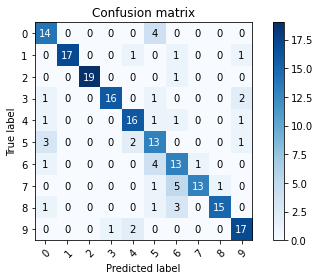

In [88]:
def plotConfusionMatrix(y_true, y_pred):
    np.set_printoptions(precision=2)
    classes = ["0", "1", "2", "3", "4", "5", "6","7","8","9"]
    title = 'Confusion matrix'
    cmap=plt.cm.Blues
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix')
    print(cm)
    #printing confusion matrix in figure format
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax    
predicted_classes=[]
#running model on test features for predictions
for i in clf.predict(testset_features):
        predicted_classes.append(i)
plotConfusionMatrix(t_labels, predicted_classes)

### Quantitative Performance

In [89]:
f1 =f1_score(t_labels, predicted_classes,average='macro')
precision = precision_score(t_labels, predicted_classes,average='macro')
recall = recall_score(t_labels, predicted_classes,average='macro')
print("Accuracy is:")
accuracy=accuracy_score(t_labels, predicted_classes)
print(accuracy)
print("F1 Score is: ")
print(f1)
print("Precision Score:")
print(precision)
print("Recall Score:")
print(recall)


Accuracy is:
0.7806122448979592
F1 Score is: 
0.7859702559879397
Precision Score:
0.8070213267125033
Recall Score:
0.7796198830409355


### Qualitative Performance

Correct Classified Images
 
Given Image: 


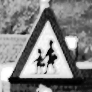

Predicted Label:  4
--------------------------------------
--------------------------------------
Given Image: 


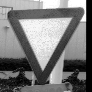

Predicted Label:  2
--------------------------------------
--------------------------------------
Given Image: 


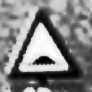

Predicted Label:  9
--------------------------------------
--------------------------------------
   Incorrectly Classified Images
 
Test Image: 


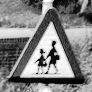

Predicted Label:  10
Given Label:  4
--------------------------------------
--------------------------------------
Test Image: 


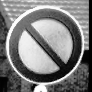

Predicted Label:  4
Given Label:  10
--------------------------------------
--------------------------------------
Test Image: 


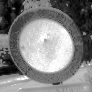

Predicted Label:  1
Given Label:  7
--------------------------------------
--------------------------------------
Test Image: 


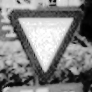

Predicted Label:  1
Given Label:  6
--------------------------------------
--------------------------------------
Test Image: 


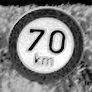

Predicted Label:  5
Given Label:  2
--------------------------------------
--------------------------------------
Test Image: 


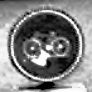

Predicted Label:  9
Given Label:  8
--------------------------------------
--------------------------------------
Test Image: 


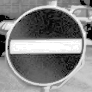

Predicted Label:  6
Given Label:  5
--------------------------------------
--------------------------------------
Test Image: 


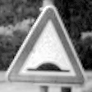

Predicted Label:  6
Given Label:  1
--------------------------------------
--------------------------------------
Test Image: 


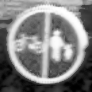

Predicted Label:  7
Given Label:  9
--------------------------------------
--------------------------------------


In [90]:
misclassified_images=[]
misclassified_labels=[]
actual_labels=[]
correct_images=[]
correct_labels=[]

for i in range(0,len(predicted_classes)):
  if(predicted_classes[i]==t_labels[i]):
    correct_images.append(testing_images[i])
    correct_labels.append(predicted_classes[i])
  else:
    misclassified_images.append(testing_images[i])
    misclassified_labels.append(predicted_classes[i])
    actual_labels.append(t_labels[i])
print("Correct Classified Images")
print(" ")
for i in range(0,len(correct_images),60):
  print("Given Image: ")
  cv2_imshow(correct_images[i])
  print("Predicted Label: ",correct_labels[i])
  print("--------------------------------------")
  print("--------------------------------------")
print("   Incorrectly Classified Images")
print(" ")
for i in range(0,len(misclassified_images),5):
  print("Test Image: ")
  cv2_imshow(misclassified_images[i])
  print("Predicted Label: ",misclassified_labels[i])
  print("Given Label: ",actual_labels[i])
  print("--------------------------------------")
  print("--------------------------------------")

## FAST and BREIF + SVM

### Feature Extraction by FAST and BREIF

In [57]:
descriptors=[]
keypoints=[]
training_dataset=[]
#creating fast object
fast = cv2.FastFeatureDetector_create()
#non-maximal supression
fast.setNonmaxSuppression(False)
#create breif object
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
for i in range(0,len(training_images)):
    #Using Fast to extract key points
    kp=fast.detect(training_images[i],None)
    #Using breif for drscriptors
    kp,descriptor = brief.compute(training_images[i], kp)
      
    if(len(kp)!=0):
      #appending the descriptors with non-Null values
      descriptors.append(descriptor)
      #appending the keypointss with non-Null values
      keypoints.append(kp)
      #appending the taining images with non-Null values
      training_dataset.append(read_training_img[1][i])
print(len(training_dataset))      

800


### Stacking of Descriptors

In [58]:
#stacking the descriptors from training examples
ds=descriptors[0]
for descriptor in descriptors[1:]:
    ds=np.vstack((ds,descriptor))

### Visualization of Keypoints

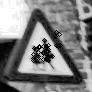

[<KeyPoint 0x7f85a205bb10>, <KeyPoint 0x7f85a205bb40>, <KeyPoint 0x7f85a205bb70>, <KeyPoint 0x7f85a205bba0>, <KeyPoint 0x7f85a205bbd0>, <KeyPoint 0x7f85a205bc00>, <KeyPoint 0x7f85a205bc30>, <KeyPoint 0x7f85a205bc60>, <KeyPoint 0x7f85a205bc90>, <KeyPoint 0x7f85a205bcc0>, <KeyPoint 0x7f85a205bcf0>, <KeyPoint 0x7f85a205bd20>, <KeyPoint 0x7f85a205bd50>, <KeyPoint 0x7f85a205bd80>, <KeyPoint 0x7f85a205bdb0>, <KeyPoint 0x7f85a205bde0>, <KeyPoint 0x7f85a205be10>, <KeyPoint 0x7f85a205be40>, <KeyPoint 0x7f85a205be70>, <KeyPoint 0x7f85a205bea0>, <KeyPoint 0x7f85a205bed0>, <KeyPoint 0x7f85a205bf00>, <KeyPoint 0x7f85a205bf30>, <KeyPoint 0x7f85a205bf60>, <KeyPoint 0x7f85a205bf90>, <KeyPoint 0x7f85a205bfc0>, <KeyPoint 0x7f85a205c030>, <KeyPoint 0x7f85a205c060>, <KeyPoint 0x7f85a205c090>, <KeyPoint 0x7f85a205c0c0>, <KeyPoint 0x7f85a205c0f0>, <KeyPoint 0x7f85a205c120>, <KeyPoint 0x7f85a205c150>, <KeyPoint 0x7f85a205c180>, <KeyPoint 0x7f85a205c1b0>, <KeyPoint 0x7f85a205c1e0>, <KeyPoint 0x7f85a205c210>, 

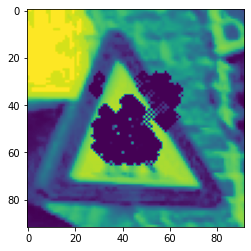

In [59]:
def show_keypoints(visual, keypoints, color = (0, 255, 255)):
  cv2_imshow(visual)
  for kp in keypoints:
    x, y = kp.pt
    plt.imshow(cv2.circle(visual, (int(x), int(y)), 2, color))

#displaying keypoints of a training example
show_keypoints(training_images[60],keypoints[60])
print(keypoints[60])

### K means Clustering

In [60]:
#converting desciptors type to float
descriptors_float=ds.astype(float)
#forming 10 clusters
k=100
voc,variance=kmeans(descriptors_float,k,1)
im_features=np.zeros((len(descriptors),k),"float32")
#calculating features
for i in range(len(descriptors)):
    words,distance=vq(descriptors[i],voc)
    for w in words:
        im_features[i][w]+=1

### SVM(Training)

In [61]:
#standardizing features
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)
#fitting SVM Model on training dataset
clf=LinearSVC(max_iter=80000)
clf.fit(im_features,np.array(training_dataset))

LinearSVC(max_iter=80000)

## Testing

### Feature Extraction

In [62]:
test_descriptors=[]
t_labels=[]
for i in range(0,len(testing_images)):
    #finding descriptors ORB
    kp, descriptor_test = brief.compute(testing_images[i],  kp)
    #appending all the descriptors, keypoints, test_labels with non-Null values
    if(len(kp)!=0):
      test_descriptors.append(descriptor_test)
      t_labels.append(testing_labels[i])
#displaying number of testing examples
print(len(t_labels))

200


### Stacking

In [63]:
test_descriptors_stacked=test_descriptors[0]
#stacking all the descriptors from all the testing examples
for descriptor in test_descriptors[1:]:
    test_descriptors_stacked=np.vstack((test_descriptors_stacked,descriptor))

In [64]:
#calculating features
testset_features=np.zeros((len(t_labels),k),"float32")
for i in range(len(t_labels)):
    words,distance=vq(test_descriptors[i],voc)
    for j in words:
        testset_features[i][j]+=1

### SVM(Testing)

In [65]:
#standardizing predictions
testset_features=stdslr.transform(testset_features)
predicted_classes=[]
#running model on test features for predictions
for i in clf.predict(testset_features):
        predicted_classes.append(i)

## Evaluation

### Confusion Matrix

Confusion matrix, without normalization
[[12  0  0  0  0  0  7  1  0  0]
 [ 0 18  2  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0]
 [ 7  0  0 13  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  2 18  0  0  0]
 [ 0  0  0  0  0  0  1 19  0  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0 20]]


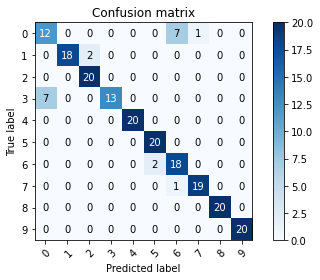

In [66]:
def plotConfusionMatrix(y_true, y_pred):
    np.set_printoptions(precision=2)
    classes = ["0", "1", "2", "3", "4", "5", "6","7","8","9"]
    title = 'Confusion matrix'
    cmap=plt.cm.Blues
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix, without normalization')
    #priniting confusion matrix in array format
    print(cm)

    #printing confusion matrix in figure format
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax    
predicted_classes=[]
#running model on test features for predictions
for i in clf.predict(testset_features):
        predicted_classes.append(i)
plotConfusionMatrix(t_labels, predicted_classes)

### Quantitiative Accuracy

In [75]:
f1 =f1_score(t_labels, predicted_classes,average='macro')
precision = precision_score(t_labels, predicted_classes,average='macro')
recall = recall_score(t_labels, predicted_classes,average='macro')
print("Accuracy is:")
accuracy=accuracy_score(t_labels, predicted_classes)
print(accuracy)
print("F1 Score is: ")
print(f1)
print("Precision Score:")
print(precision)
print("Recall Score:")
print(recall)

Accuracy is:
0.9
F1 Score is: 
0.8988002424730114
Precision Score:
0.9092068457857932
Recall Score:
0.9


### Qualitative Accuracy

Correct Classified Images
 
Given Image: 


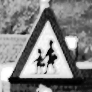

Predicted Label:  4
--------------------------------------
--------------------------------------
Given Image: 


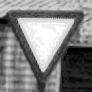

Predicted Label:  6
--------------------------------------
--------------------------------------
Given Image: 


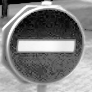

Predicted Label:  5
--------------------------------------
--------------------------------------
   Incorrectly Classified Images
 
Test Image: 


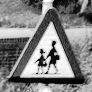

Predicted Label:  1
Given Label:  4
--------------------------------------
--------------------------------------
Test Image: 


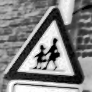

Predicted Label:  1
Given Label:  4
--------------------------------------
--------------------------------------
Test Image: 


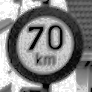

Predicted Label:  3
Given Label:  2
--------------------------------------
--------------------------------------
Test Image: 


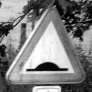

Predicted Label:  7
Given Label:  1
--------------------------------------
--------------------------------------


In [73]:
misclassified_images=[]
misclassified_labels=[]
actual_labels=[]
correct_images=[]
correct_labels=[]

for i in range(0,len(predicted_classes)):
  if(predicted_classes[i]==t_labels[i]):
    correct_images.append(testing_images[i])
    correct_labels.append(predicted_classes[i])
  else:
    misclassified_images.append(testing_images[i])
    misclassified_labels.append(predicted_classes[i])
    actual_labels.append(t_labels[i])
print("Correct Classified Images")
print(" ")
for i in range(0,len(correct_images),60):
  print("Given Image: ")
  cv2_imshow(correct_images[i])
  print("Predicted Label: ",correct_labels[i])
  print("--------------------------------------")
  print("--------------------------------------")
print("   Incorrectly Classified Images")
print(" ")
for i in range(0,len(misclassified_images),5):
  print("Test Image: ")
  cv2_imshow(misclassified_images[i])
  print("Predicted Label: ",misclassified_labels[i])
  print("Given Label: ",actual_labels[i])
  print("--------------------------------------")
  print("--------------------------------------")